# <u>Artificial Neural Network Implementation Using PyTorch Framework</u>

In [1]:
import numpy as np 
import pandas as pd 
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms import ToTensor , Lambda
from sklearn.model_selection import train_test_split
from torch.utils.data import SubsetRandomSampler
import os
from torch import nn
import matplotlib.pyplot as plt

In [2]:
path = '/kaggle/input/mnist-dataset'
for dirname, _, filenames in os.walk(f'{path}'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mnist-dataset/sample_submission.csv
/kaggle/input/mnist-dataset/train.csv
/kaggle/input/mnist-dataset/test.csv


In [ ]:
train_df = pd.read_csv(f"{path}/train.csv")
test_df = pd.read_csv(f"{path}/test.csv")
print(train_df.shape , test_df.shape)
print("Train Cols : " , train_df.columns)
print("Test Cols : " , test_df.columns)
print(" Label -  " , [i for i in train_df.columns if i not in test_df.columns] )

In [ ]:
#Pytorch Dataset Class
class CustomMNISTDataset(Dataset):
    def __init__(self, csv_name, img_dir, transform=None, target_transform=None , label_name = "label"):
        
        self.img_filename = csv_name
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform
        self.label_name = label_name
        
        img_path = os.path.join(self.img_dir, self.img_filename)
        self.img_df = pd.read_csv(img_path)

    def __len__(self):
        return len(self.img_df)

    def __getitem__(self, idx):
        
        # Extracting all the other columns except label_name
        img_cols = [ i for i in self.img_df.columns if i not in self.label_name]
        
        image = self.img_df.iloc[[idx]][img_cols].values

        # Reshaping the array from 1*784 to 28*28
        image = image.reshape(28,28)
        # image = image.astype(float)

        # Scaling the image so that the values only range between 0 and 1
        image = image/255.0
        
        
        if self.transform:
            image = self.transform(image)
    
        image = image.to(torch.float)    
        
        if self.label_name in self.img_df.columns:
            label = int(self.img_df.iloc[[idx]][self.label_name].values)
            if self.target_transform:
                label = self.target_transform(label)
            return image, label
        
        # Exceptions for test where labels are absent
        else :
            return image

In [ ]:
#Targets distribution check
train_df['label'].value_counts().sort_index()

In [ ]:
indices = list(range(len(train_df)))

train_indices , test_indices = train_test_split(indices, test_size=0.1, stratify=train_df['label'])

print(len(train_indices))
print(len(test_indices))
print(len(train_df))

train_subset = train_df.loc[train_indices]
val_subset = train_df.loc[test_indices]

print("Distribution of target values in training dataset ; ")
print( train_subset['label'].value_counts().sort_index() / train_subset['label'].value_counts().sort_index().sum() )

print("Distribution of target values in validation dataset ; ")
print( val_subset['label'].value_counts().sort_index() / val_subset['label'].value_counts().sort_index().sum() )

In [ ]:
# Creating a temp dataset
train_csv_name = "train.csv"
test_csv_name = "test.csv"
img_dir = path

# Converting X variables to Tensors
transforms = transforms.Compose( [transforms.ToTensor() ,] )

# Converting y-labels to one hot encoding
target_transform = Lambda(lambda y: torch.zeros(
    len(train_df['label'].unique()), dtype=torch.float).scatter_(dim=0, index=torch.tensor(y), value=1))

label_name = "label"

train_dataset = CustomMNISTDataset(csv_name = train_csv_name , img_dir = img_dir , transform = transforms , target_transform = target_transform , label_name = label_name)

In [ ]:
# Inspecting the first line item under dataset
x0 , y0 = train_dataset[0]
print(x0.shape, y0)

In [ ]:
# Ploting some of the datapoints in the dataset
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
figure.add_subplot(rows, cols, 1)
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_dataset), size=(1,)).item()
    sample_img , sample_lbl = train_dataset[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(sample_lbl)
    plt.axis("off")
    plt.imshow(sample_img.squeeze(), cmap="gray")
plt.show()

In [ ]:
## Checking if a GPU exists in the current pc. 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
x0 = x0.to(device)
print("x0" , x0.is_cuda)


In [ ]:
# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(test_indices)

train_dataloader = torch.utils.data.DataLoader(train_dataset , batch_size=1, sampler=train_sampler, num_workers=8)
valid_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=1, sampler=valid_sampler, num_workers=8)

x0 , y0 = next(iter(train_dataloader))
print(x0, y0)

In [ ]:
class MyNeuralNetwork(nn.Module):
    def __init__(self, sizes, epochs, lr):
        super(MyNeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.sizes = sizes
        self.epochs = epochs
        self.lr = lr
        
        # number of nodes in each layer
        input_layer=self.sizes[0]
        hidden_1=self.sizes[1]
        hidden_2=self.sizes[2]
        output_layer=self.sizes[3]

        self.params = {
            'W1':torch.randn(hidden_1, input_layer) * np.sqrt(1. / hidden_1),
            'W2':torch.randn(hidden_2, hidden_1) * np.sqrt(1. / hidden_2),
            'W3':torch.randn(output_layer, hidden_2) * np.sqrt(1. / output_layer)
        }

    def sigmoid(self, x, derivative=False):
        if derivative:
            return (torch.exp(-x))/((torch.exp(-x)+1)**2)
        return 1/(1 + torch.exp(-x))

    def softmax(self, x, derivative=False):
      # Numerically stable with large exponentials
        exps = torch.exp(x - x.max())
        if derivative:
            return exps / torch.sum(exps, axis=1) * (1 - exps / torch.sum(exps, axis=1))
        return exps / torch.sum(exps, axis=1)
    
    def cross_entropy_loss(self, y_true, y_pred, derivative=False):
      # Clip the prediction values to prevent log(0) error
        y_pred = torch.clip(y_pred, 1e-15, 1 - 1e-15)
        if derivative:
            return -(y_true/y_pred)
      # Calculate the cross-entropy loss for each sample
        loss = -torch.sum(y_true * torch.log(y_pred), axis=1)
      # Return the average loss over the batch
        return torch.mean(loss)

    
    def forward(self, X):
        params = self.params
        params['A0'] = self.flatten(X)
        params['Z1'] = torch.matmul(params['A0'], torch.t(params['W1']))
        params['A1'] = self.sigmoid(params['Z1'])
        params['Z2'] = torch.matmul(params['A1'], torch.t(params['W2']))
        params['A2'] = self.sigmoid(params['Z2'])
        params['Z3'] = torch.matmul(params['A2'], torch.t(params['W3']))
        params['O'] = self.softmax(params['Z3'])
        #print(f"output --- {params['O']}")
        return params['O']
    
    def backward(self, y_train, output):
        params = self.params
        change_w = {}

        # Calculate W3 update
        error = self.cross_entropy_loss(y_train, output, derivative=True) * self.softmax(params['O'], derivative=True)
        #print(error.shape)
        #print(params['Z3'].shape)
        change_w['W3'] = torch.matmul(torch.t(params['A2']), error)
        #print(f"W3 --- {change_w['W3'].shape}")

        # Calculate W2 update
        error = torch.matmul(error, params['W3']) * self.sigmoid(params['A2'], derivative=True)
        #print(f"shape error --- {(torch.flatten(error)).shape}")
        #print(error)
        #print(f"shape params --- {(torch.flatten(params['A1'])).shape}")
        change_w['W2'] = torch.matmul(torch.t(params['A1']), error)
        #print(f"W2 --- {change_w['W2'].shape}")
        
        # Calculate W1 update
        error = torch.matmul(error, params['W2']) * self.sigmoid(params['A1'], derivative=True)
        change_w['W1'] = torch.matmul(torch.t(params['A0']), error)
        #print(f"W1 --- {change_w['W1'].shape}")

        return change_w

    def update_network_parameters(self, changes_to_w):      
        for key, value in changes_to_w.items():
            self.params[key] -= self.lr * torch.t(value)
            
    def train(self, X, y):
        o = self.forward(X)
        c_w = self.backward(y, o)
        self.update_network_parameters(c_w)
        return o
    
    def saveWeights(self, model):
        torch.save(model, "NN")
        
    def predict(self, x_test):
        print ("Predicted data based on trained weights: ")
        print ("Input (scaled): \n" + str(x_test))
        print ("Output: \n" + str(self.forward(x_test)))

In [ ]:
NN = MyNeuralNetwork(sizes=[784, 128, 64, 10], epochs=10, lr=0.001)
preds = torch.tensor([])
pred_loss = []
pred_true = []

In [14]:
for i in range(1000):
    X, y = next(iter(train_dataloader))
    X = (X * 0.99) + 0.01
    if (i % 100) == 0:
        print ("#" + str(i) + " Loss: " + str(NN.cross_entropy_loss(y, NN(X)).detach().item()))
    o = NN.train(X, y)
    pred_loss.append(NN.cross_entropy_loss(y, NN(X)).detach().item())
    #pred = torch.argmax(o)
    #preds = torch.cat((preds, pred == torch.argmax(y)), dim=0)
#accuracy = torch.mean(preds)
#print('Accuracy: {0:.2f}%'.format(
#        accuracy * 100
##     ))
#NN.saveWeights(NN)
#NN.predict(x0)

#200 Loss: 2.969630241394043
#300 Loss: 2.8175833225250244
#700 Loss: 2.551488161087036


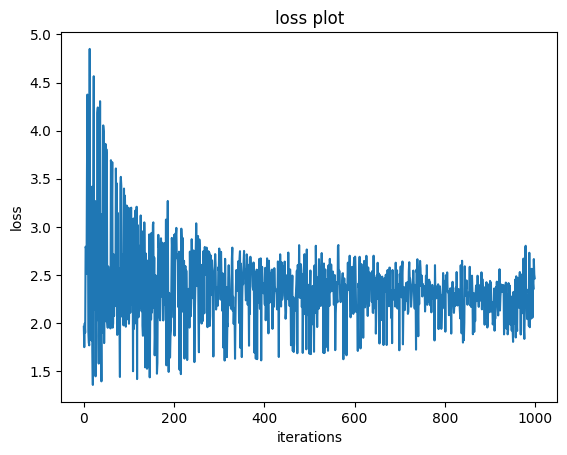

In [16]:
plt.plot(list(np.arange(1000)), pred_loss)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.title("loss plot")
plt.show()